In [1]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap

In [2]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [3]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


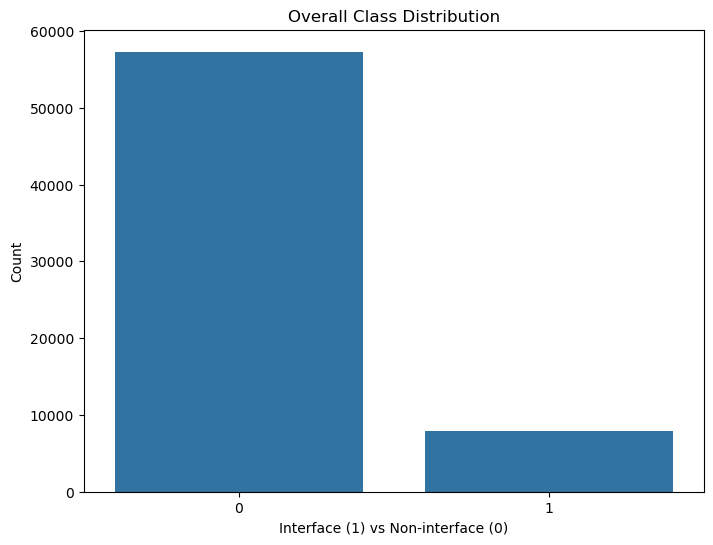

In [4]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [5]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 90% train and 10% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.2, random_state=22)

# Second split: Split the temporary groups into validation and test equally (15% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

########
train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
val_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [6]:
####################################### calcualte class weight of train on the validation
class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
print(class_weights)

{0: 0.575627174510163, 1: 3.805690072639225}


In [7]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 182
Unique uniprot_ids in Validation: 23
Unique uniprot_ids in Test: 23


In [8]:
######################################### undersampelin
# Initialize the RandomUnderSampler
rus_50 = RandomUnderSampler(random_state=42)
rus_30 = RandomUnderSampler(random_state=42,sampling_strategy=0.3)

# apply the undersampler on the training data
X_train, y_train = rus_30.fit_resample(X_train, y_train)


# shape of the training data before and after undersampling
print("Undersampled training set shape:", X_train.shape, y_train.shape)
print("Undersampled val set shape:", X_val.shape, y_val.shape)
print("Undersampled test set shape:", X_test.shape, y_test.shape)

print("Origina dataset columns:")
print(df.columns)

print("Train set columns:")
print(X_train.columns)

print("\nValidation set columns:")
print(X_val.columns)

print("\nTest set columns:")
print(X_test.columns)

Undersampled training set shape: (26849, 151) (26849,)
Undersampled val set shape: (6287, 151) (6287,)
Undersampled test set shape: (7217, 151) (7217,)
Origina dataset columns:
Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob_sheet',
       ...
       'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W',
       'aa_Y'],
      dtype='object', length=157)
Train set columns:
Index(['normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob_sheet',
       'prob_helix', 'prob_coil', 'pssm_A', 'pssm_R', 'pssm_N',
       ...
       'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W',
       'aa_Y'],
      dtype='object', length=151)

Validation set columns:
Index(['normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob

C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [9]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
#################################################### Linear regression

# Initialize and fit the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#y_pred_LR = model.predict(X_test)
y_pred_LR = model.predict_proba(X_test)[:, 1]

# Convert continuous predictions to binary class labels using a threshold of 0.5
y_pred_class_LR = (y_pred_LR >= 0.5).astype(int)

# Evaluate the classifier
accuracy_LR = accuracy_score(y_test, y_pred_class_LR)
precision_LR = precision_score(y_test, y_pred_class_LR, zero_division=0)
recall_LR = recall_score(y_test, y_pred_class_LR, zero_division=0)
f1_LR = f1_score(y_test, y_pred_class_LR, zero_division=0)


Accuracy: 0.87
Precision: 0.29
Recall: 0.09
F1 Score: 0.14
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6394
           1       0.29      0.09      0.14       823

    accuracy                           0.87      7217
   macro avg       0.59      0.53      0.53      7217
weighted avg       0.82      0.87      0.84      7217



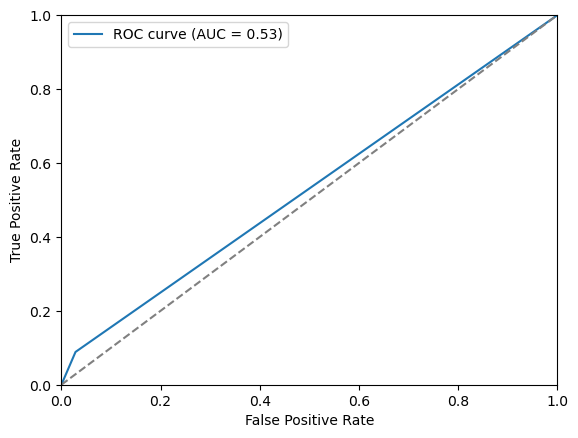

In [11]:
################################################## print results Linear regression

print(f"Accuracy: {accuracy_LR:.2f}")
print(f"Precision: {precision_LR:.2f}")
print(f"Recall: {recall_LR:.2f}")
print(f"F1 Score: {f1_LR:.2f}")

# Compute ROC curve with continuous probabilities
print(classification_report(y_test, y_pred_class_LR, zero_division=0))
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_class_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [12]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Validation Accuracy (RF): 0.7698130532610385


In [13]:
################################################# get best scores hyperparamter 
y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

Accuracy: 0.89
Precision: 0.29
Recall: 0.00
F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.29      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.59      0.50      0.47      7217
weighted avg       0.82      0.89      0.83      7217



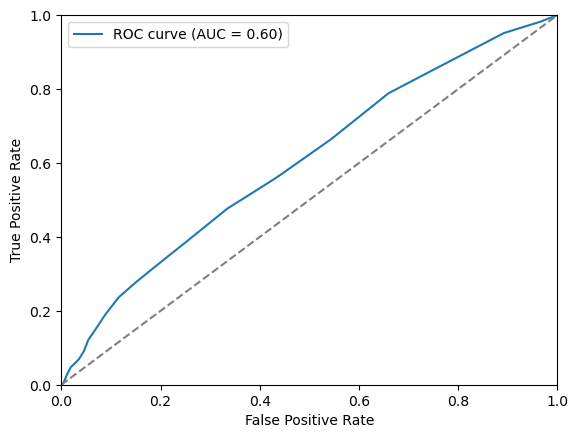

In [14]:
############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [15]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.7263744019184142


In [16]:
############################################### running XGBoost

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)



XGBoost Classifier Performance:
Accuracy: 0.89
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



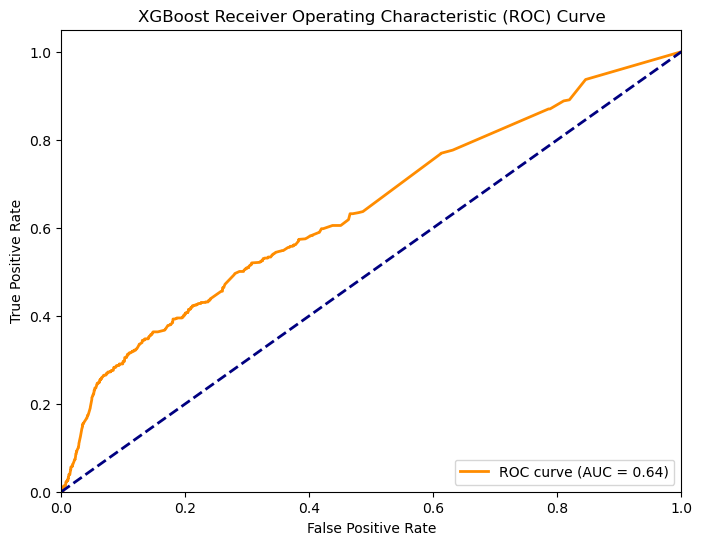

In [17]:
############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
###################################################### train model and set the class weights

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4523 - auc: 0.5823 - loss: 0.9271 - val_accuracy: 0.3116 - val_auc: 0.6997 - val_loss: 0.9296
Epoch 2/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4113 - auc: 0.6572 - loss: 0.7918 - val_accuracy: 0.3359 - val_auc: 0.7139 - val_loss: 0.9649
Epoch 3/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4446 - auc: 0.6959 - loss: 0.7684 - val_accuracy: 0.3359 - val_auc: 0.7327 - val_loss: 0.9379
Epoch 4/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4566 - auc: 0.7087 - loss: 0.7531 - val_accuracy: 0.3553 - val_auc: 0.7268 - val_loss: 0.9177
Epoch 5/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4758 - auc: 0.7198 - loss: 0.7420 - val_accuracy: 0.3916 - val_auc: 0.7324 - val_loss: 0.9007
Epoch 6/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4760 - auc: 0.7216 - loss: 0.7371 - val_accuracy: 0.3724 - val_auc: 0.7245 - val_loss: 0.9181
Epoch 7/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# 2. Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy: 0.56
Precision: 0.17
Recall: 0.71
F1 Score: 0.27

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.54      0.69      6394
           1       0.17      0.71      0.27       823

    accuracy                           0.56      7217
   macro avg       0.55      0.63      0.48      7217
weighted avg       0.85      0.56      0.64      7217



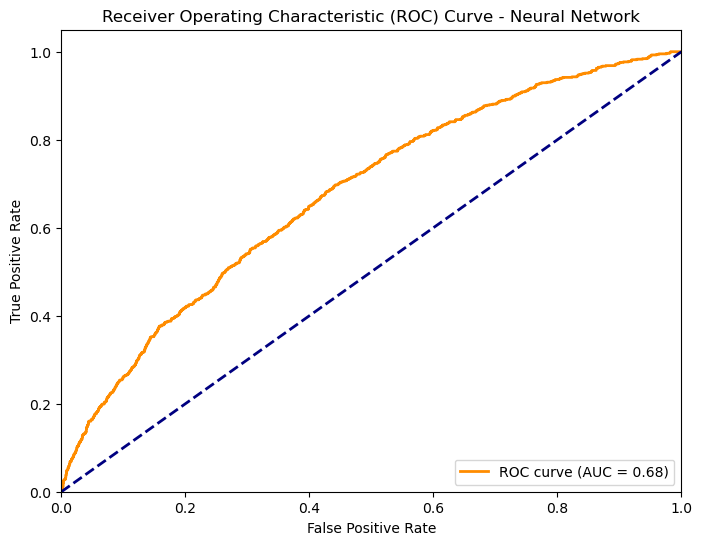

In [21]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# 5. Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

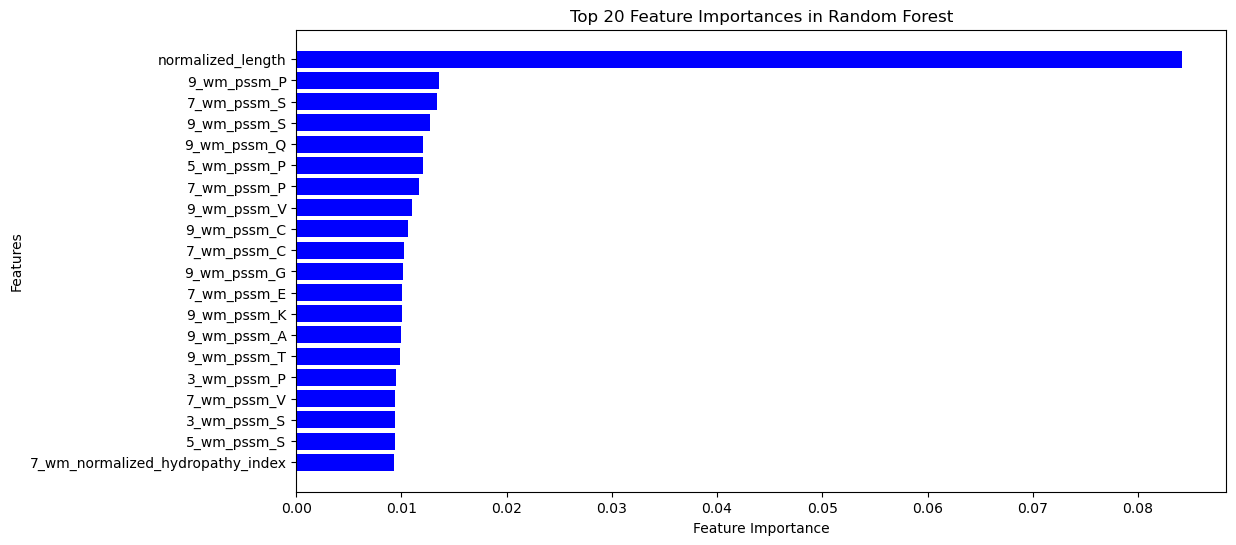

In [22]:
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_test = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names_test)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_test,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()


In [23]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(7217, 151))']
  

<Figure size 640x480 with 0 Axes>

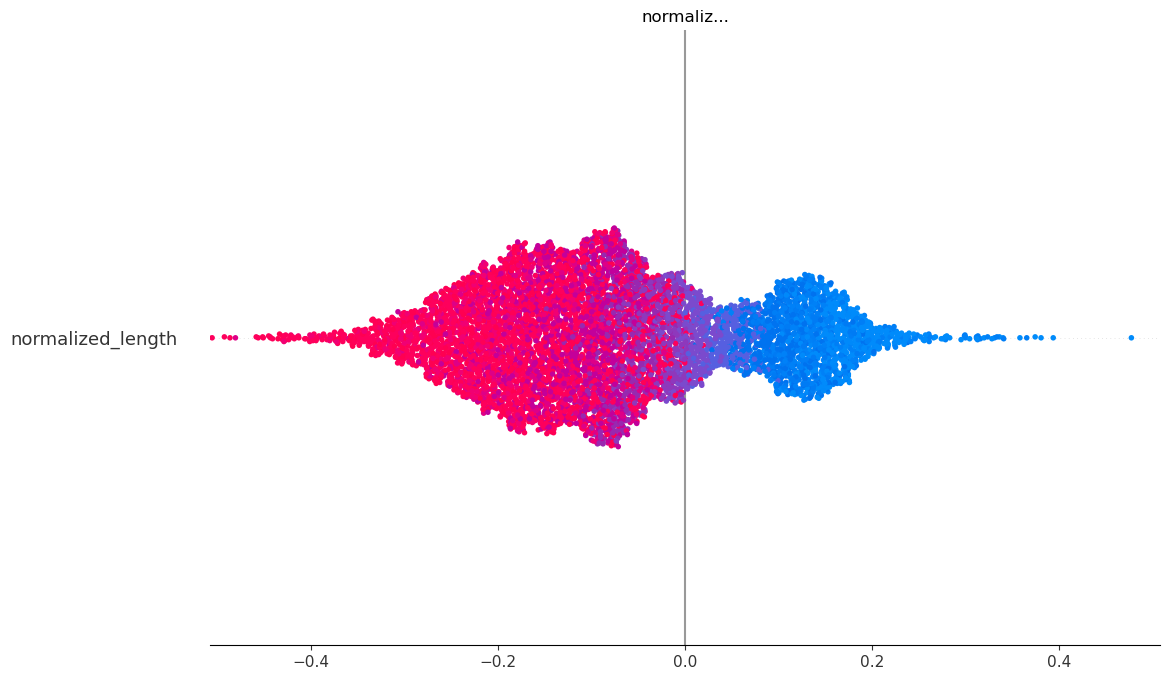

In [24]:
#global feature importance
test_df = test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_2 = test_df.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_test_names = pd.DataFrame(X_test, columns=feature_names_2)

# Then pass them to the summary plot:
shap.summary_plot(shap_values, X_test_names)

In [25]:
def build_model(hp):
    """Build and compile a Keras model, returning it."""
    model = Sequential()

    # Tune the number of units in the first layer
    units_input = hp.Int('units_input', min_value=128, max_value=512, step=128)
    model.add(Dense(units_input, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
    )
    return model


In [26]:
class MyHyperband(kt.Hyperband):
    """
    Custom Hyperband tuner that also tunes 'batch_size' via run_trial()
    and returns final metrics to avoid the 'None' return error.
    """

    def run_trial(self, trial, x, y, **fit_kwargs):
        hp = trial.hyperparameters

        # 1) Define any training-related hyperparameters here
        fit_kwargs['batch_size'] = hp.Choice('batch_size', [32, 64, 128])
        # You could also tune epochs if you want:
        # fit_kwargs['epochs'] = hp.Int('epochs', min_value=10, max_value=30, step=5)

        # 2) Build the model using the current hyperparameters
        model = self.hypermodel.build(hp)

        # 3) Train the model
        history = model.fit(x, y, **fit_kwargs)

        # 4) Retrieve final metrics from history
        #    (Make sure 'val_loss' and 'val_AUC' are being tracked!)
        final_val_loss = history.history['val_loss'][-1]
        final_val_auc  = history.history['val_AUC'][-1]

        # 5) Update the trial with these metrics so the tuner can compare
        self.oracle.update_trial(
            trial.trial_id,
            {'val_loss': final_val_loss, 'val_AUC': final_val_auc}
        )

    
        # 7) **Return** the final metrics to avoid the None return error
        return {'val_loss': final_val_loss, 'val_AUC': final_val_auc}


In [27]:
tuner = MyHyperband(
    build_model,
    objective=kt.Objective("val_AUC", direction="max"),
    max_epochs=20,   # Hyperband max epochs
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="nn_tuning"
)

# Early stopping to avoid overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=20,                    # or the tuned value if you included 'epochs' in run_trial
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early],
    verbose=1
)


Trial 30 Complete [00h 00m 28s]
val_AUC: 0.7163141369819641

Best val_AUC So Far: 0.7316573858261108
Total elapsed time: 00h 06m 31s


In [28]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print("units_input:", best_hps.get('units_input'))

print("learning_rate:", best_hps.get('learning_rate'))
print("batch_size:", best_hps.get('batch_size'))


Best hyperparameters:
units_input: 128
learning_rate: 0.0005
batch_size: 64


In [29]:
best_model = tuner.hypermodel.build(best_hps)

# Optionally train for more epochs with the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    batch_size=best_hps.get('batch_size'),
    epochs=50,  # more epochs if you want
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early]
)


Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5968 - accuracy: 0.4940 - loss: 0.9740 - val_AUC: 0.6990 - val_accuracy: 0.3611 - val_loss: 1.0014
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6802 - accuracy: 0.4892 - loss: 0.8085 - val_AUC: 0.7144 - val_accuracy: 0.3857 - val_loss: 0.9309
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6950 - accuracy: 0.4992 - loss: 0.7741 - val_AUC: 0.7263 - val_accuracy: 0.3891 - val_loss: 0.9135
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7115 - accuracy: 0.5018 - loss: 0.7570 - val_AUC: 0.7205 - val_accuracy: 0.3870 - val_loss: 0.9171
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7281 - accuracy: 0.5066 - loss: 0.7334 - val_AUC: 0.7321 - val_accuracy: 0.3938 - val_loss: 0.9068
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7302 - accuracy: 0.5058 - loss: 0.7307 - val_AUC: 0.7317 - val_accuracy: 0.3986 - val_loss: 0.8959
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
y_pred_probs_NN = best_model.predict(X_test).flatten()
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

print("Accuracy:", accuracy_NN)
print("Precision:", precision_NN)
print("Recall:", recall_NN)
print("F1 Score:", f1_NN)


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
Accuracy: 0.5976167382568934
Precision: 0.17595764559327312
Recall: 0.6865127582017011
F1 Score: 0.28011898859692613


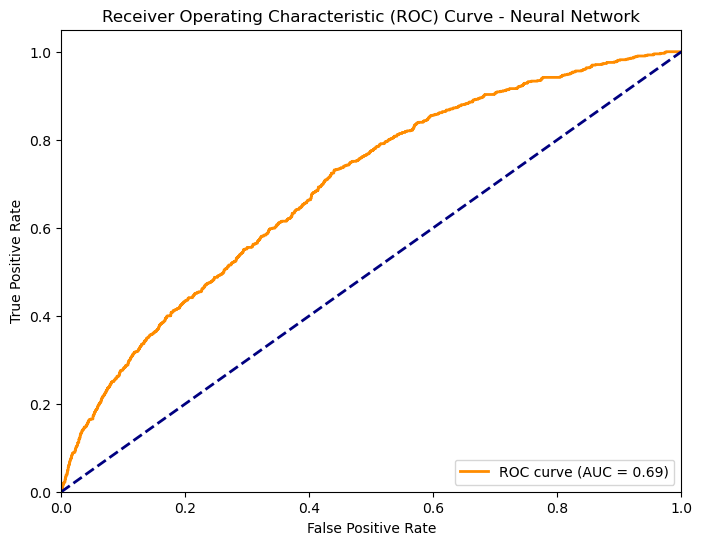

In [31]:
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

In [32]:
#############################################use shap for other model

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(best_model, background)

# Compute SHAP values for test data
shap_values_2 = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_352
Received: inputs=['Tensor(shape=(7217

<Figure size 640x480 with 0 Axes>

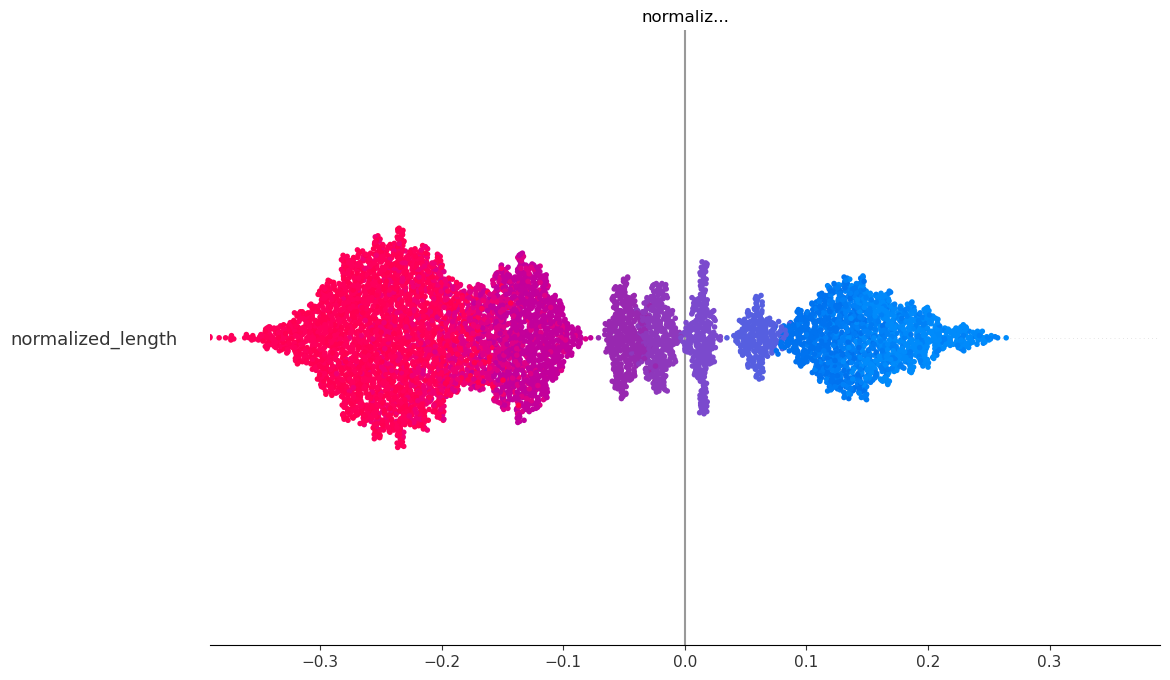

In [33]:
# Then pass them to the summary plot:
shap.summary_plot(shap_values_2, X_test_names)

In [41]:
X_train_length = X_train[:, 0].reshape(-1, 1)  
   
X_test_length  = X_test[:, 0].reshape(-1, 1) 


In [43]:
model_single = LogisticRegression()
model_single.fit(X_train_length, y_train)

LogisticRegression()

In [45]:
y_pred_probs_LR_single = model_single.predict_proba(X_test_length)[:, 1]

# Convert to binary predictions using a threshold of 0.5
y_pred_class_LR_single = (y_pred_probs_LR_single >= 0.5).astype(int)

# Evaluate with "LR_single" variable names
accuracy_LR_single  = accuracy_score(y_test, y_pred_class_LR_single)
precision_LR_single = precision_score(y_test, y_pred_class_LR_single, zero_division=0)
recall_LR_single    = recall_score(y_test, y_pred_class_LR_single, zero_division=0)
f1_LR_single        = f1_score(y_test, y_pred_class_LR_single, zero_division=0)

print("Accuracy (LR_single):", accuracy_LR_single)
print("Precision (LR_single):", precision_LR_single)
print("Recall (LR_single):", recall_LR_single)
print("F1 (LR_single):", f1_LR_single)

Accuracy (LR_single): 0.8859636968269364
Precision (LR_single): 0.0
Recall (LR_single): 0.0
F1 (LR_single): 0.0


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



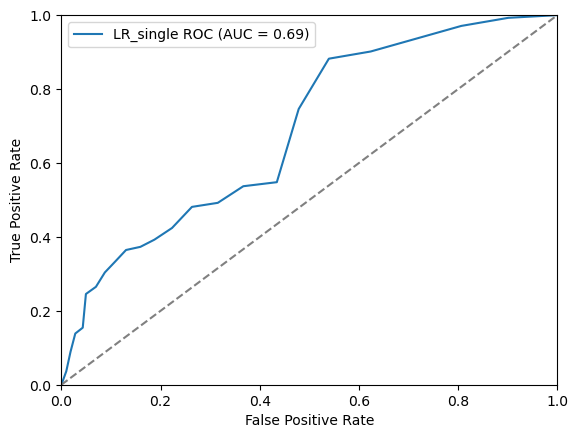

In [47]:
################################################## print results Linear regression
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

# 2. Compute ROC curve with continuous probabilities
fpr_LR_single, tpr_LR_single, thresholds_LR_single = roc_curve(y_test, y_pred_probs_LR_single)
roc_auc_LR_single = auc(fpr_LR_single, tpr_LR_single)

# 3. Plot the ROC curve
plt.plot(fpr_LR_single, tpr_LR_single, label=f"LR_single ROC (AUC = {roc_auc_LR_single:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()